Before anything else, you need to set up your environment properly. 
- in terminal, run `$ ./SETUP_ENV.sh`
- then in this jupyter notebook select the "sparc_20250225" conda environment as your python kernel (top right)

In [1]:
# Set constants
DEVICE = "cpu"
FS_SPARC_CODE = 50
DATA_ROOT = "../data"
# suppress warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import os
import glob
from pathlib import Path
import numpy as np
import bisect
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
from matplotlib.patches import ConnectionPatch
import scipy as sp
from scipy.interpolate import interp1d
import librosa
import textgrid
%load_ext autoreload
%autoreload 2
import importlib
# import sparc
sys.path.append("../")
from sparc import load_model
import copy
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime





In [3]:
coder = load_model("en", device=DEVICE, use_penn=True)
coder.inverter.linear_model

load_model v3
load_model v3
Using PENN for pitch tracking.


Linear(in_features=1024, out_features=12, bias=True)

# Helper functions

In [4]:
hprc_channels = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
mngu_channels = [
    'T3_x', 'T3_y',   # TD → T3
    'T2_x', 'T2_y',   # TB → T2
    'T1_x', 'T1_y',   # TT → T1
    'JAW_x','JAW_y',  # LI → JAW
    'UL_x', 'UL_y',   # UL → UL
    'LL_x', 'LL_y'    # LL → LL
]
hprc2mngu = {
    'LIX': 'JAW_x',
    'LIY': 'JAW_y',
    'ULX': 'UL_x',
    'ULY': 'UL_y',
    'LLX': 'LL_x',
    'LLY': 'LL_y',
    'TTX': 'T1_x',
    'TTY': 'T1_y',
    'TBX': 'T2_x',
    'TBY': 'T2_y',
    'TDX': 'T3_x',
    'TDY': 'T3_y',
}
mngu2hprc = {v: k for k, v in hprc2mngu.items()}
idxs_hprc2mngu = [hprc_channels.index(mngu2hprc[c]) for c in mngu_channels]
idxs_mngu2hprc = [mngu_channels.index(hprc2mngu[c]) for c in hprc_channels]

In [5]:
# Define EMA principle comonent transforms 
# ... matrices were previously computeted in matlab, we just read them in here

idxs_tongue = np.array([1, 2, 3, 4, 5, 6]) - 1
idxs_jaw = np.array([7, 8]) - 1
idxs_lips = np.array([9, 10, 11, 12]) - 1
idxs_UL = np.array([9, 10]) - 1
PC = pd.read_csv(f'../PC-12d.csv')
labels_PC = ['T_pc1', 'T_pc2', 'T_pc3', 'T_pc4', 'T_pc5', 'T_pc6', 'J_pc1', 'J_pc2', 'L_pc1', 'L_pc2', 'L_pc3', 'L_pc4']

def m2M(m, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  # m should be (12, ns)

  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL
  
  # # 1d version
  # mask_jawUL = np.ones_like(m)
  # mask_jawUL[np.concat([idxs_jaw, idxs_UL]),:] = 0

  # m_jawtile = np.tile(m[idxs_jaw,:], 6)

  # m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  # M = np.dot(np.linalg.inv(PC), m_jawrel)


  mask_jawUL = np.ones_like(m)
  # print(mask_jawUL)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL]),:] = 0

  m_jawtile = np.tile(m[idxs_jaw,:], [6, 1])

  m_jawrel = m - np.multiply(mask_jawUL, m_jawtile)

  M = np.dot(np.linalg.inv(PC), m_jawrel)
  assert(M.shape[0]==12)

  return M


def M2m(M, PC):
  # convert relative positions of articulators 'm' to PC-positions of articulators M
  global idxs_tongue
  global idxs_jaw
  global idxs_lips
  global idxs_UL

  mask_jawUL = np.ones_like(M)
  mask_jawUL[np.concat([idxs_jaw, idxs_UL]), :] = 0

  m = np.dot(PC, M)
  
  m_jawtile = np.tile(m[idxs_jaw, :], [6, 1])
  m = m + np.multiply(mask_jawUL, m_jawtile)

  # assert(m.flatten().size==12)
  assert(m.shape[0]==12)

  return m


In [6]:
color_code = {"UL":mpl.colors.to_rgb("#EE3A5B"),
              "LL":mpl.colors.to_rgb("#FFD155"),
              "LI":mpl.colors.to_rgb("#959595"),
              "TT":mpl.colors.to_rgb("#43B962"),
              "TB":mpl.colors.to_rgb("#C44B9F"),
              "TD":mpl.colors.to_rgb("#0093B7"),
              "Loudness":mpl.colors.to_rgb("#FB754D"),
              "Pitch":mpl.colors.to_rgb("#FB754D"),}

HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

def plot_art(ax, art, labels=None, gap=5, skip_y=False,color=None, series_name="", alpha=1.0, lw=2, plot_velocity=False, pitch=None, loudness=None, periodicity=None):
    yticks=[]
    ytick_labels=[]
    # labels = reversed["UL","LL", "LI", "TT", "TB", "TD"]
    # chidxs = []
    # HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    # channel_label = HPRC_channel_label
    # for l in labels:
    #     chidxs.append(HPRC_channel_label.index(l+"X"))
    #     chidxs.append(HPRC_channel_label.index(l+"Y"))
    labels = labels.copy() # avoid mutating the object passed 
    if labels is None:
        labels = ['T3', 'T2', 'T1', 'JAW', 'UL', 'LL']
        labels = [l+d for l in labels for d in ["_x", "_y"]]
    if pitch is not None:
        labels.append('pitch')
        art = np.column_stack([art, pitch])
    if loudness is not None:
        labels.append('loudness')    
        art = np.column_stack([art, loudness])
    if periodicity is not None:
            labels.append('periodicity')    
            art = np.column_stack([art, periodicity])
    channel_label = list(labels) # make a copy of labels
    chidxs = np.arange(0, len(channel_label))


    time = np.arange(0, art.shape[0]) / 50
    # print(len(art))
    # print(time)
    for i, ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
        else:
            art_name = ch_label
            if color is None:
                color = color_code[art_name]
        x = art[:,ch_i]
        if i == 0 and series_name:
            ax.plot(time, x - gap * i, color=color, alpha=alpha, lw=lw, label=series_name)
        else:
            ax.plot(time, x - gap * i, color=color, alpha=alpha, lw=lw)

        # ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw, label=series_name)
        if plot_velocity:
            ax.plot(time, 2*np.concatenate(([0], np.diff(x))) - gap*i,color='r',alpha=alpha*0.5,lw=1)

        yticks.append(-gap*i)

    # i = i+1
    # # diffs = np.diff(art, axis=0)
    # # maxdiffs = np.max(diffs, axis = 1)
    # diffs = np.vstack([np.zeros((1, 12)), np.abs(np.diff(art, axis=0))])
    # maxdiffs = np.max(diffs, axis = 1)
    # ax.plot(time, 2*maxdiffs-gap*i,color='r',alpha=alpha*0.5,lw=lw)
    # yticks.append(-gap*i)
    # ytick_labels.append('~max velocity')

    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    # xticks= np.arange(0,len(art),50)
    # xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    # ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    # ax.set_xlim(0,len(art))
    # ax.legend()
    ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center')
    

    return yticks

In [7]:


from matplotlib.animation import FFMpegWriter
ffmpeg_path = "/projectnb/busplab/lbullock/.conda/envs/sparc_20250225/bin/ffmpeg"
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path



def animate_ema(df_ema, filepath_out, sensor_neutral, colors=None, trail_length=5, interval=50):
    """
    Create an animation of EMA articulators with fading comet trails, synchronized by timestamp.

    Parameters:
    df_ema (DataFrame): DataFrame containing columns ['series', 'time', 'T3_x', 'T3_y', ..., 'LL_x', 'LL_y'].
    filepath_out (str): Path to save the animation (e.g., 'animation.mp4').
    sensor_neutral (list): List of neutral (x,y) positions for sensors.
    colors (dict): Dictionary mapping 'series' values to colors (e.g., {'original':'black', 'perturbed':'red'}).
    trail_length (int): Length of the comet trail.
    interval (int): Interval between frames in milliseconds.
    """

    if colors is None:
        colors = {'original': 'black', 'perturbed': 'red'}

    sensors = ['T3', 'T2', 'T1', 'JAW', 'UL', 'LL']

    # Sort by time and group by 'series'
    df_ema = df_ema.sort_values(by='time')
    groups = df_ema.groupby('series')

    # Get unique sorted time points
    time_points = df_ema['time'].unique()

    fig, ax = plt.subplots(figsize=(6, 6))

    # Setting up plot limits
    padding = 1
    x_cols = [f'{s}_x' for s in sensors]
    y_cols = [f'{s}_y' for s in sensors]

    x_all = df_ema[x_cols].values
    y_all = df_ema[y_cols].values

    ax.set_xlim([-4, 8])
    ax.set_ylim([-6, 4])
    # ax.set_xlim(np.min(x_all) - padding, np.max(x_all) + padding)
    # ax.set_ylim(np.min(y_all) - padding, np.max(y_all) + padding)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('EMA Sensor Motion with Fading Comet Trails')
    ax.grid(True)
    ax.set_aspect('equal')

    scatters_dict = {}
    for series, group in groups:
        color = colors.get(series, 'gray')
        scatters = [ax.scatter([], [], color=color, s=50, alpha=1-(i/trail_length)) for i in range(trail_length)]
        scatters_dict[series] = scatters

    time_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, fontsize=12,
                        verticalalignment='top', horizontalalignment='right')

    def init():
        for scatters in scatters_dict.values():
            for scatter in scatters:
                scatter.set_offsets(np.empty((0, 2)))
        time_text.set_text('')
        return sum(scatters_dict.values(), []) + [time_text]

    def update(frame):
        current_time = time_points[frame]
        artists = []

        for series, group in groups:
            scatters = scatters_dict[series]

            current_group = group[group['time'] <= current_time]

            for trail_idx in range(trail_length):
                idx = -(trail_length - trail_idx)
                if abs(idx) <= len(current_group):
                    pos = current_group.iloc[idx]
                    sensor_positions = np.array([
                        [pos[f'{sensor}_x'], pos[f'{sensor}_y']] for sensor in sensors
                    ]) + sensor_neutral
                    scatters[trail_idx].set_offsets(sensor_positions)
                else:
                    scatters[trail_idx].set_offsets(np.empty((0, 2)))

                artists.append(scatters[trail_idx])

        time_text.set_text(f't={current_time:.2f}')
        artists.append(time_text)

        return artists

    ani = FuncAnimation(fig, update, frames=len(time_points), init_func=init,
                        blit=True, interval=interval)

    # Save animation (mp4 recommended)
    ani.save(filepath_out, writer='ffmpeg')
    plt.close(fig)


# Example usage (assuming df_ema and sensor_neutral are prepared as specified):
# sensor_neutral = np.array([[5.4407711, -0.27898258], [3.9024611, 0.090298139], [2.2748213, -0.49493390],
#                            [0.82840538, -2.8019209], [-1.0039096, -0.083905414], [-0.67326981, -2.5571942]])
# animate_ema(df_ema, 'ema_animation.mp4', sensor_neutral, {'original': 'black', 'perturbed': 'red'})

# SPARC helper functions

In [8]:
def sparc_analyse_wav(filename):
    # filename is the name of a wav file. in this function, we want to analyse the file and return sparc ema traces, MFCCs, and a spectrogram

    # target is an object that has already had target = sparc_analyse_wav(target_filename). 
    # if target is not None, we will attempt to warp the file to 
    # f = '/projectnb/busplab/lbullock/sparc_sample_audio/pAHk_aligned.wav'
    # f = Path('/projectnb/busplab/lbullock/sparc_sample_audio/pAHk_aligned.wav')

    # (filepath.parent / (filepath.stem + "_resynth" + filepath.suffix))
    # f = folder / "never-stole_she.wav"

    f = Path(filename)


    c = {}
    print(coder)
    # c["code_orig"] = copy.deepcopy(codes[0])
    c["code_orig"] = coder.encode(f)
    # resynthesize
    wav = coder.decode(**c["code_orig"])
    sf.write((f.parent / (f.stem + "_resynth" + f.suffix)), wav, coder.sr)

    c["fname"] = f.stem
    c["loudness"] = np.squeeze(c["code_orig"]['loudness'])
    c["ema"] = np.squeeze(c["code_orig"]['ema']) 
    c["pitch"] = np.squeeze(c["code_orig"]['pitch']) 
    c["periodicity"] = np.squeeze(c["code_orig"]['periodicity']) 

    c["time"] = np.arange(1, c["ema"].shape[0]+1) / FS_SPARC_CODE  

    # # Trim to equal length if needed (e.g., remove last sample)
    # if loudness is not None and loudness.shape[0] == ema.shape[0] + 1:
    #     loudness = loudness[:-1]
    # Assume: ema (T1, D), pitch (T2,), loudness (T3,)
    T = max(c["ema"].shape[0],
        c["pitch"].shape[0] if c["pitch"] is not None else 0,
        c["loudness"].shape[0] if c["loudness"] is not None else 0)
    if c["ema"].shape[0] < T:
        pad_width = ((0, T - c["ema"].shape[0]), (0, 0))
        c["ema"] = np.pad(c["ema"], pad_width, mode='edge')
    for feat in ["pitch", 'loudness', 'periodicity', 'time']:     
        if c[feat] is not None and c[feat].shape[0] < T:
            c[feat] = np.pad(c[feat], (0, T - c[feat].shape[0]), mode='edge')
    # if c["loudness"] is not None and c["loudness"].shape[0] < T:
    #     c["loudness"] = np.pad(c["loudness"], (0, T - c["loudness"].shape[0]), mode='constant')
    # if c["periodicity"] is not None and c["periodicity"].shape[0] < T:
    #     c["periodicity"] = np.pad(c["periodicity"], (0, T - c["periodicity"].shape[0]), mode='constant')

    # [print(k, c[k].shape) for k in c.keys() if k in ['ema', 'acoustic_wvlm', 'pitch', 'periodicity', 'loudness', 'time']]
    
    c["ema_pc"] = m2M(c["ema"].T, PC).T # convert from raw EMA sensors to EMA-principle components space



    # ------ 
    # Load audio and compute MFCCs
    c["wav"], c["wav_fs"] = librosa.load(f, sr=None)
    dur  = c["wav"].shape[0] / c["wav_fs"] 


    c["mfcc"] = librosa.feature.mfcc(y=c["wav"], sr=c["wav_fs"], n_mfcc=13)
    c["mfcc_time"] = (np.arange(0, c["mfcc"].shape[1]) / c["mfcc"].shape[1] * dur).squeeze()
    c["mfcc_delta"]= librosa.feature.delta(c["mfcc"].T)

    c["specgram"] = librosa.feature.melspectrogram(y=c["wav"], sr=c["wav_fs"], n_mels=128, fmax=8000)
    c["specgram_time"] = (np.arange(0, c["specgram"].shape[1]) / c["specgram"].shape[1] * dur).squeeze()

    c["mfcc"] = c["mfcc"].T
    c["specgram"] = c["specgram"].T
    return c


In [9]:
def dilate(code, perturbation, coder=None, PC=PC,it_idx=None):
    """
    Apply smooth temporal perturbations to a SPARC speech code object and synthesize audio.

    Parameters:
    - code: dict, the base speech code
    - perturbations: dict, each describing a perturbation:
        {
            "onset": float, onset of dilation
            "offset": float, offset of dilation
            "increase": float, describes by how much dime will be dilated (newtime is offset-onset+increase)
            "tau":float, slope parameter of sigmoid functions
        }
    - fs: int, sampling frequency of the signals
    - coder: coder object with .decode() method (optional, for resynthesis)

    Returns:
    - code with a new code["pert"] dictionary
    """
    pert = {}



    # Clone original features
    for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
        if key in code:
            pert[key] = np.copy(code[key])
    if "epsilon" in perturbation :
        epsilon= perturbation["epsilon"]
    else :
        epsilon=0

    time = code["time"]
    

    t1 = perturbation["onset"]
    t2= perturbation["offset"]


    duration_increase = perturbation["increase"]  # 
    tau = perturbation["tau"]    

    # Find right indexes if onsett and offset are not
    t1_real = min(time, key=lambda x: abs(x - t1))
    t2_real = min(time, key=lambda x: abs(x - t2))
    i1 = bisect.bisect_left(time, t1_real)
    i2 = bisect.bisect_left(time, t2_real)

    # Cut into three lists 
    time_before = time[:i1]
    time_trans = time[i1:i2]
    time_after = time[i2:]

    # Create a Double logistic gate filter to apply to the time series of time
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    f = sigmoid((time_trans - t1_real- epsilon) / tau) - sigmoid((time_trans - t2_real+ epsilon) / tau)

    # 

    dt_trans = np.diff(time_trans, prepend=time_trans[0])
    dt_trans_warped = dt_trans * ( f+1) 

    # --- Ajustement pour obtenir exactement la durée cible ---
    orig_duration = np.sum(dt_trans)
    target_duration = orig_duration + duration_increase
    scale = target_duration / np.sum(dt_trans_warped)
    dt_trans_warped *= scale
    tt = time_trans[0] + np.cumsum(dt_trans_warped)
    # Reconstituer tout l’axe temporel
    time_after_shifted = time_after + duration_increase
    warped_time = np.concatenate([time_before, tt, time_after_shifted])


    # 2. Create a new regular time based on the wrapped time
    time_new_linear = np.arange(time[0], warped_time[-1], 1/FS_SPARC_CODE)
    

    # 3.Interpolation of features based on new time
    for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
        if key not in pert:
            continue
        y = pert[key]
        
        # 
        if y.ndim == 1:
            interp = interp1d(warped_time, y, bounds_error=False, fill_value=np.mean(y))
            pert[key] = interp(time_new_linear)
        else:
            interp = interp1d(warped_time, y, axis=0, bounds_error=False, fill_value=np.mean(y))
            pert[key] = interp(time_new_linear)

    pert['time'] = time_new_linear
    description = f"start@{t1:.1f}end{t2:.2f}"
    pert["fname"] = code["fname"] + "pert" #change pert_desc to something more explicit
    
    # Optional: synthesize perturbed audio
    if coder is not None:
        resynth_input = {
            "ema": pert["ema"][np.newaxis, :, :],
            "loudness": pert["loudness"][np.newaxis, :, np.newaxis],
            "pitch": pert["pitch"][np.newaxis, :, np.newaxis],
            "periodicity": pert["periodicity"][np.newaxis, :, np.newaxis],
            "spk_emb": code["code_orig"]["spk_emb"].copy()
        }
        wav = coder.decode(**resynth_input)
        pert["wav"] = wav

    if it_idx ==None :
        code["pert"] = pert.copy()
        for key in code:
            if key not in pert:
                code["pert"][key] = code[key]


    else :
        code2=code
        code = pert.copy()
        for key in code2:
            if key not in pert:
                code[key] = code2[key]
    print(code.keys())
    return code


def pitch_frquency_shift(code, perturbation, coder=None, PC=PC,it_idx=None):
    """
    Apply smooth temporal perturbations to a SPARC speech code object and synthesize audio.

    Parameters:
    - code: dict, the base speech code
    - perturbations: dict, each describing a perturbation:
        {
            "onset": float, onset of dilation
            "offset": float, offset of dilation
            "increase": float, describes by how much dime will be dilated (newtime is offset-onset+increase)
            "tau":float, slope parameter of sigmoid functions
        }
    - fs: int, sampling frequency of the signals
    - coder: coder object with .decode() method (optional, for resynthesis)

    Returns:
    - code with a new code["pert"] dictionary
    """
    pert = {}



    # Clone original features
    for key in ["ema", "ema_pc", "pitch", "loudness", "periodicity"]:
        if key in code:
            pert[key] = np.copy(code[key])
    if "epsilon" in perturbation :
        epsilon= perturbation["epsilon"]
    else :
        epsilon=0

    time = code["time"]
    
    print(perturbation)
    t1 = perturbation["onset"]
    t2= perturbation["offset"]

    
    mult_factor = perturbation["increase"]  # 
    tau = perturbation["tau"]    

    # Find right indexes if onsett and offset are not
    t1_real = min(time, key=lambda x: abs(x - t1))
    t2_real = min(time, key=lambda x: abs(x - t2))
    i1 = bisect.bisect_left(time, t1_real)
    i2 = bisect.bisect_left(time, t2_real)

    indexes=np.linspace(0,i2-i1,i2-i1)


    # Create a Double logistic gate filter to apply to the time series of time
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    f = sigmoid((indexes - epsilon) / tau) - sigmoid((indexes - (i2-i1)+ epsilon) / tau)

    factor=1+f*mult_factor
    plt.plot(factor)
    if perturbation["type"]=="pitch" :
        pert["pitch"][i1:i2]=pert["pitch"][i1:i2]*factor
    else :
        pert["loudness"][i1:i2]=pert["loudness"][i1:i2]*factor
    pert["fname"] = code["fname"] + "pert" #change pert_desc to something more explicit
    
    # Optional: synthesize perturbed audio
    if coder is not None:
        resynth_input = {
            "ema": pert["ema"][np.newaxis, :, :],
            "loudness": pert["loudness"][np.newaxis, :, np.newaxis],
            "pitch": pert["pitch"][np.newaxis, :, np.newaxis],
            "periodicity": pert["periodicity"][np.newaxis, :, np.newaxis],
            "spk_emb": code["code_orig"]["spk_emb"].copy()
        }
        wav = coder.decode(**resynth_input)
        pert["wav"] = wav
    # If code[pert]  do not exist, it is easy to just replace it

    if it_idx ==None :
        code["pert"] = pert.copy()
        for key in code:
            if key not in pert:
                code["pert"][key] = code[key]

    # If code[pert] already exists, use a temporary copy to help genreate the right format
    else :
        code_temp=code
        code = pert.copy()
        for key in code_temp:
            if key not in pert:
                code[key] = code_temp[key]
    print(code.keys())
    return code




In [39]:
def successive_dilation(code, perturbation,seq_raw=None, coder=None, PC=PC) :
    #Test if windows are overlapping and sort peruration order of application from left to right
    onset_list=[]
    offset_list=[]
    for pert in perturbation :
        onset_list+=[pert["onset"]]
        offset_list+=[pert["offset"]]
    idx_sorted_onset_list=sorted(range(len(onset_list)),key=lambda k:onset_list[k])
    
    intervals = sorted(zip(onset_list, offset_list), key=lambda x: x[0])

    #Check over all intervals if one starts before all other ones are over
    for i in range( len(intervals)):
        for j in range(i + 1,  len(intervals)):
            if intervals[j][0] < intervals[i][1]:
                raise ValueError(f"dilations {i} and {j} are overlapping")
            
    #Apply transformation from left to right in chronological order
    pert_idx=1
    for pert_idx in idx_sorted_onset_list :
        if pert_idx==idx_sorted_onset_list[-1] :
            loc_coder=coder
        else :
            loc_coder=coder
            
        pert=perturbation[pert_idx]
        # to avoid creating things like code[pert][pert]....[pert]

        if "pert" in code  :
            code["pert"]=dilate(code["pert"],pert,coder=loc_coder,PC=PC,it_idx=0)
        else :
            code=dilate(code,pert,coder=loc_coder,PC=PC)
        
        # Increase next onsets and offsets by "increase" duration t match new timings

        for inc_onset in idx_sorted_onset_list[pert_idx:] :
            perturbation[inc_onset]["onset"]+=pert["increase"]
            perturbation[inc_onset]["offset"]+=pert["increase"]
        pert_idx+=1
    total_dilat=0
    if seq_raw!= None :
        for ind in range(len(seq_raw)) :
            seq_raw[ind]["onset"]=seq_raw[ind]["onset"]+total_dilat
            total_dilat+=seq_raw[ind]["increase"]
            seq_raw[ind]["offset"]=seq_raw[ind]["offset"]+total_dilat

    if seq_raw!=None :
        return code,seq_raw
    else :
        return code



def successive_perturbation(code, perturbation, coder=None, PC=PC) :
    perturbation_non_time=[]
    perturbation_time=[]
    code.pop("pert", None)
    for dic in perturbation :
        if dic["type"]=="loudness" or dic["type"]=="pitch" :
            perturbation_non_time.append(dic)
        else :
            perturbation_time.append(dic)
    for dic in perturbation_non_time :
        if "pert" in code :
            code["pert"]=pitch_frquency_shift(code["pert"],dic,coder=coder, PC=PC,it_idx=0)
        else :
            code=pitch_frquency_shift(code,dic,coder=coder, PC=PC)
    code=successive_dilation(code, perturbation_time, coder=coder, PC=PC)
    return code
    

def take_betweem_M(dic,M,N):
    out = {}
    for key, value in dic.items():
        if key in ["ema", "pitch", "loudness", "periodicity"]:
            out[key] = value[M:N]   # marche pour list, numpy array, etc.
        else:
            # si ce n'est pas indexable, on ignore ou on copie tel quel
            out[key] = value
    
    return out


# Prosody modulation: Visualize differences in SPARC EMA trajectories 

In [35]:
dir_data = Path(f"{DATA_ROOT}")
# "target" refers to the template audio file that defines neutral prosody
c = dir_data / "import.wav"
c = sparc_analyse_wav(c)
trajectory=c


dict_keys(['ema', 'ema_pc', 'pitch', 'loudness', 'periodicity', 'time', 'fname', 'wav', 'code_orig', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time', 'pert'])
dict_keys(['ema', 'ema_pc', 'pitch', 'loudness', 'periodicity', 'time', 'fname', 'wav', 'code_orig', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time', 'pert'])
{'type': 'pitch', 'onset': 0.8, 'offset': 1.2, 'increase': 0.09999999999999998, 'tau': 0.4, 'epsilon': 2}
dict_keys(['code_orig', 'fname', 'loudness', 'ema', 'pitch', 'periodicity', 'time', 'ema_pc', 'wav', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time', 'pert'])
{'type': 'loudness', 'onset': 0.8, 'offset': 1.2, 'increase': 0.5999999999999999, 'tau': 0.9, 'epsilon': 2}
dict_keys(['ema', 'ema_pc', 'pitch', 'loudness', 'periodicity', 'fname', 'wav', 'code_orig', 'time', 'wav_fs', 'mfcc', 'mfcc_time', 'mfcc_delta', 'specgram', 'specgram_time', 'pert'])
{'type': 'pitch', 'onset': 1.2, 'offset': 1.7, 'in

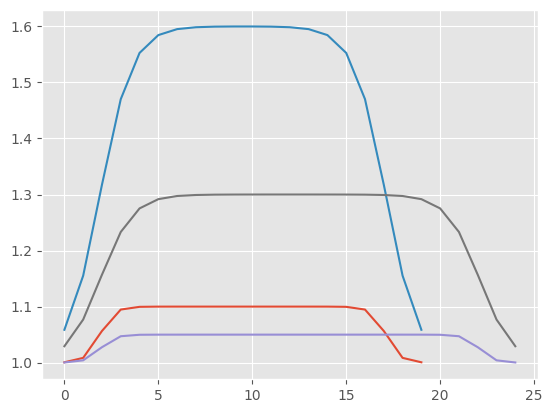

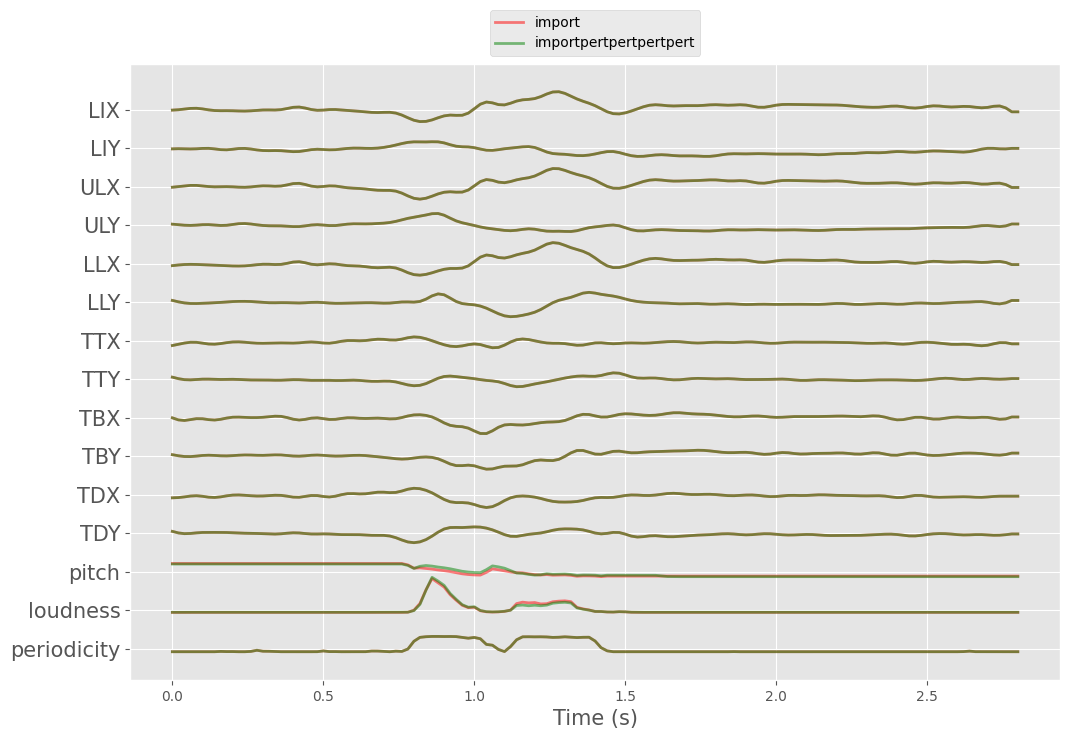

In [ ]:
'''Sentence in english with prosodic information'''
'''Retrieve from julia syllabification'''
'''Retrieve from Latane motor programs duration for each syllable and create dic of standard production'''
sequence_raw=[{"label":"im","onset":0.8,"offset":1,"prom":1.2},{"label":"port","onset":1,"offset":1.4,"prom":1.1}] 
''''''

def prominence_to_pert(seq) :
    pert_list=[]
    for dic in seq :
        increase=dic["prom"]-1
        pert_list.append({"type":"time","onset":dic["onset"],"offset":dic["offset"],"increase":increase,"tau":0.3,"epsilon":0.2})
        dic["increase"]=increase
    return pert_list
def prominence_to_emp(seq) :
    pert_list=[]
    for dic in seq :
        increase=dic["prom"]-1
        if increase!=0 :
            increase_pitch=increase/2
            increase_loud=increase*3
            pert_list.append({"type":"pitch","onset":dic["onset"],"offset":dic["offset"],"increase":increase_pitch,"tau":0.4,"epsilon":2})
            pert_list.append({"type":"loudness","onset":dic["onset"],"offset":dic["offset"],"increase":increase_loud,"tau":0.9,"epsilon":2})

        dic["increase"]=increase
    return pert_list

time_pert_list= prominence_to_pert(sequence_raw)

trajectory,sequence_dil=successive_dilation(trajectory,time_pert_list,seq_raw=sequence_raw,coder=coder)

emp_pert_list= prominence_to_emp(sequence_dil)

c=successive_perturbation(trajectory,emp_pert_list,coder=coder)





sf.write(dir_data / (c["pert"]["fname"] + ".wav"), c['pert']['wav'], coder.sr)
ipd.display(ipd.Audio(c['pert']['wav'], rate=coder.sr))   

c_plot = [c, c['pert']]
c_plot_colors = ['r', 'g', 'b']

# Plot and save
fig, ax = plt.subplots(figsize=(12, 8))
for i, code in enumerate(c_plot):
    # _, fname = os.path.split(files[i])
    fname = code['fname']
    plot_art(
        ax, code["ema"], # ema, ema_pc
        labels=hprc_channels, # hprc_channels, labels_PC
        color=c_plot_colors[i],
        series_name=fname, 
        gap=7, alpha=0.5, lw=2,
        pitch= sp.stats.zscore(code['pitch']), # sp.stats.zscore .... pitches[i], # pitches[i],
        loudness= sp.stats.zscore(code['loudness']), 
        periodicity= sp.stats.zscore(code['periodicity'])
    )



In [13]:


def add(syllables,dic) :
    '''
    Take as an input a list of syllables and generate spark code from sparc trajectories
    '''
    code = {key: [] for key in ["ema", "pitch", "loudness", "periodicity"]}
   
    for syll in syllables:
        syllable_sparcs = dic[syll]
        
        for key in ["ema", "pitch", "loudness", "periodicity"]:
            seg = syllable_sparcs[key]
            code[key].append(seg)
    for t in code:
        code[t] = np.concatenate(code[t], axis=0)
    code["time"]=np.arange(len(code["loudness"])) / FS_SPARC_CODE

    resynth_input = {
        "ema": code["ema"][np.newaxis, :, :],
        "loudness": code["loudness"][np.newaxis, :, np.newaxis],
        "pitch": code["pitch"][np.newaxis, :, np.newaxis],
        "periodicity": code["periodicity"][np.newaxis, :, np.newaxis],
        "spk_emb": dic[syll]["code_orig"]["spk_emb"]
    }
    wav = coder.decode(**resynth_input)
    code["wav"]=wav

    return code



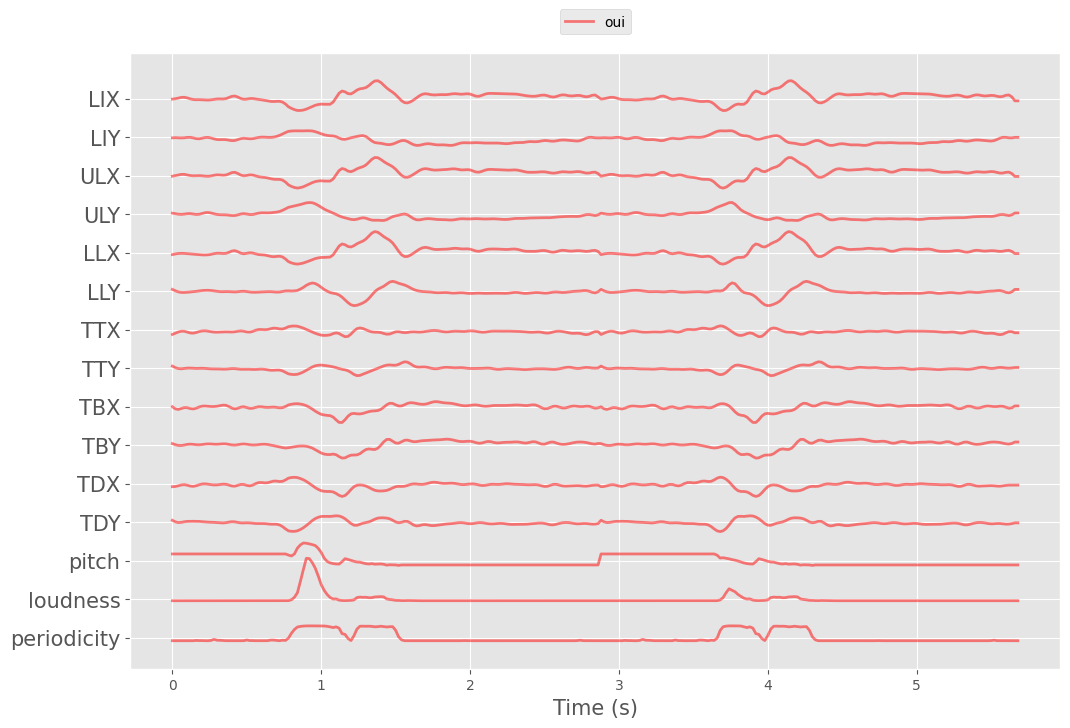

In [14]:


im_idx=int(0.815*50)
port_idx=int(1*50)
port_end=int(1.372*50)

im=take_betweem_M(c,im_idx,port_idx)
port=take_betweem_M(c,port_idx,port_end)


dic={"import" :c, "import2":c["pert"]}
k=add(["import2","import"],dic)
c_plot = [k]
c_plot_colors = ['r', 'g', 'b']
ipd.display(ipd.Audio(k['wav'], rate=coder.sr))   
# Plot and save

fig, ax = plt.subplots(figsize=(12, 8))
for i, code in enumerate(c_plot):
    # _, fname = os.path.split(files[i])


    plot_art(
        ax, code["ema"], # ema, ema_pc
        labels=hprc_channels, # hprc_channels, labels_PC
        color=c_plot_colors[i],
        series_name='oui', 
        gap=7, alpha=0.5, lw=2,
        pitch= sp.stats.zscore(code['pitch']), # sp.stats.zscore .... pitches[i], # pitches[i],
        loudness= sp.stats.zscore(code['loudness']), 
        periodicity= sp.stats.zscore(code['periodicity'])
    )